### Dependencies
- exotk
- priors
- seaborn
- astropy
- george

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

In [2]:
import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

In [3]:
import astropy
import astropy.stats
from collections import OrderedDict
import priors
from priors import PriorSet, UP, NP, JP
import mcFunc
import batman
import gptransitfit
import george
print("Using george version:",george.__version__)
print("george version should be",'0.3.1.dev0')

Using george version: 0.3.1.dev0
george version should be 0.3.1.dev0


In [4]:
# Making sure that these are under "../src/"
print(gptransitfit.__file__)
print(priors.__file__)
print(mcFunc.__file__)

../src/gptransitfit.pyc
../src/priors.pyc
../src/mcFunc.pyc


In [5]:
import astropylib.nexopl
nex = astropylib.nexopl.NExSciEphem()
planet = nex.get_exoplanet("K2-104b")
planet.describe()

Planet name: 	 K2-104 b 
TRANSITFLAG: 	 1 
Period (d):  	 1.974190 +0.000110 -0.000110
T0: 	 	 2457140.381170 +0.002680 -0.002610
Duration (d): 	 0.052917 +0.008750 -0.016250
Rp/Rs:	 	 $0.0365_{-0.0024}^{+0.0024}$ 
Depth (mmag):	 1.332
Inc: 	 	 $88.0_{-1.4}^{+1.4}$
e: 	 	 0.18
a (AU): 	 $nan_{-0.0}^{+0.0}$ 
a/Rs: 	 	 nan
a/Rs (ratdor): 	 11.000

=== Host star Photometry ===
RA: 	 	 08h38m32.82s
DEC: 	 	 +19d46m25.8s
Spectral Type: 	  nan 
Rs: 	 	 $0.48_{-0.020}^{+0.020}$
Ms: 	 	 $0.51_{-0.020}^{+0.020}$
Teff: 	 	 $3660.0_{-67.0}^{+67.0}$
[Fe/H]: 	 $0.14_{-0.040}^{+0.040}$
log(g): 	 $nan_{-0.0}^{+0.0}$
Optmag: 	  15.149 (Band: Kepler-band)
U: 	 	  nan 
B: 	 	  nan 
V: 	 	  nan 
R: 	 	  nan 
I: 	 	  nan 
J: 	 	  12.878 
H: 	 	  12.252 
K: 	 	  12.014 


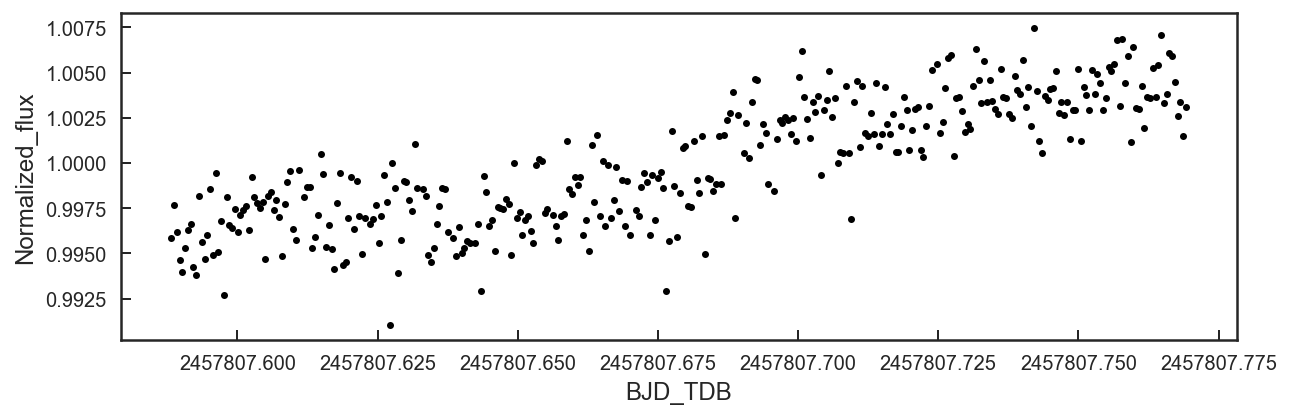

In [6]:
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
np.random.seed(sum(map(ord, "aesthetics")))
sns.set(font_scale=1,style='white')#,font='sans-serif',color_codes=False)  # crazy big
sns.set_style({"xtick.direction": "in","ytick.direction": "in"}, {"xtick.major.size": 5,"ytick.major.size": 5})
aijdata= pd.read_csv("../data/k2_104b/Processed_k2104b_fast_quad_4x4_1129micronfocus_measurements.xls",sep="\t")


fig = plt.figure(figsize=(10,3))
time=aijdata['BJD_TDB']
rel_flux=aijdata['rel_flux_T1']/np.nanmean(aijdata['rel_flux_T1'])

plt.plot(time,rel_flux,'k.')
plt.xlabel('BJD_TDB',fontsize=12)
plt.ylabel('Normalized_flux',fontsize=12)

0.280441153631


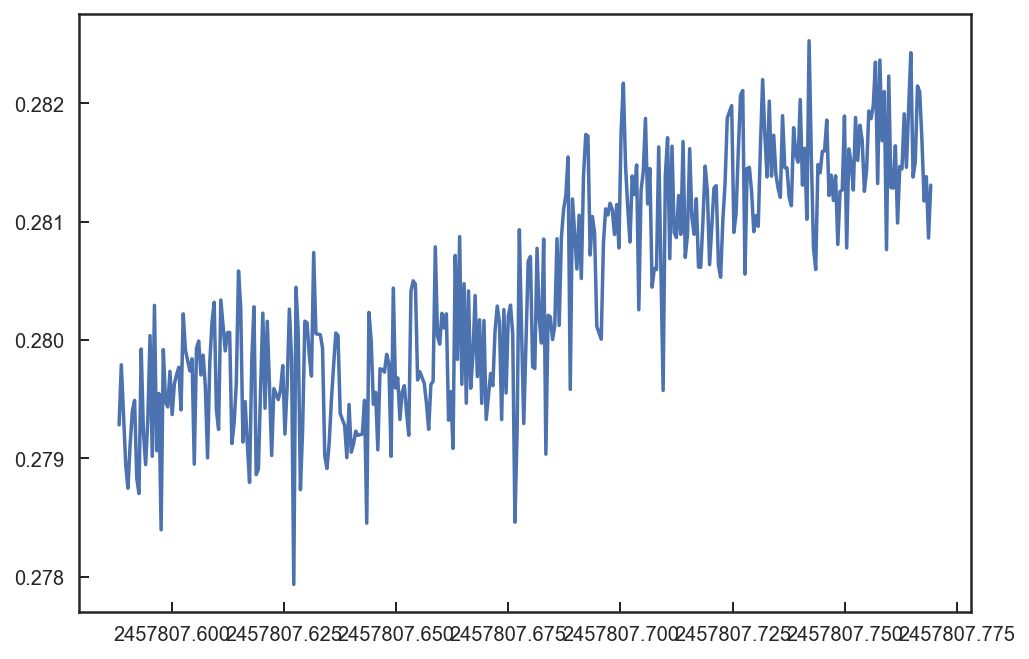

In [7]:
df = pd.read_csv("../data/k2_104b/Processed_k2104b_fast_quad_4x4_1129micronfocus_measurements.xls",sep="\t")
plt.plot(df.BJD_TDB,df.rel_flux_T1)
print(np.mean(df.rel_flux_T1))

In [8]:
import astropylib
ii   = planet.get_attributeAndError("_pl_orbincl")[0:2]
pp   = planet.get_attributeAndError("_pl_orbper")[0:2]
rprs = planet.get_attributeAndError("_pl_ratror")[0:2]
aRs  = planet.get_attributeAndError("_pl_ratdor")[0:2]

print("log(P)",mcFunc.err_logP_from_p(pp))
print("cos(i)",mcFunc.err_cosi_from_i(ii))
print("RpRs",rprs)
print("log(aRs)",mcFunc.err_logaRs_from_aRs(aRs))

log(P) [0.29538894771592994, 2.4198477861481265e-05]
cos(i) [0.03489949670250108, 0.024419724623997257]
RpRs (0.036499999999999998, 0.0023999999999999998)
log(aRs) [1.0413926851582251, 0.094755159687982204]


In [10]:
class GPLPFunction(object):
    """
    An object to do a GP fit using George. Implements the Baysian Log probability function as a callable class.
    Use with 
    
    NOTES:
    - priorDict has to be in the same order as TransitModel
    """
    class TransitModel(george.modeling.Model):
        parameter_names = ("t0","p","i","k","a","baseline")
        u1 = 0.3708
        u2 = 0.2911
        params = batman.TransitParams()
        #tm = pytransit.MandelAgol()
        def get_value(self, t):
            self.params.t0 = self.t0
            self.params.per = 10.**self.p
            self.params.inc = np.arccos(self.i)*180./np.pi
            self.params.rp = self.k
            self.params.a = 10.**self.a
            self.params.ecc = 0.
            self.params.w = 0.
            self.params.u = [self.u1,self.u2]
            self.params.limb_dark = "quadratic"
            self.params.fp = 0.001
            self.transitmodel = batman.TransitModel(self.params, t, transittype='primary')
            return self.transitmodel.light_curve(self.params)*self.baseline
            #return self.tm.evaluate(t,self.k,[self.u1,self.u2],self.t0,self.p,self.a,np.deg2rad(self.i))*self.baseline
    
    def __init__(self):
        """
        Add data and priors here
        """
        #df = pd.read_csv("/Users/gks/Box Sync/TRANSITS/k2_28b/17_32_48/Processed_K2-28b-diffuserin-30s_measurements.xls",sep="\t")
        df = pd.read_csv("../data/k2_104b/Processed_k2104b_fast_quad_4x4_1129micronfocus_measurements.xls",sep="\t")
        df = df[0:-3]
        data = astropy.stats.sigma_clipping.sigma_clip(df.rel_flux_T1.values)
        m = data.mask
        self.x = df.HJD_UTC.values[~m]
        self.y = df.rel_flux_T1.values[~m]
        self.yerr = df.rel_flux_err_T1.values[~m]
        self.A = np.var(self.y) # Has to be positive, in kernel it takes log
        self.B = 10. # Has to be positive, in kernel it takes log
        self.priorDict = OrderedDict()
        self.priorDict["t0"]         = NP(2457807.652352379  , 0.00268    ,"t0"      ,r"$T_C$")
        self.priorDict["logP"]       = NP(0.29538894771592994, 2.4198477861481265e-05,"logP"    ,r"$\log(P)$")
        self.priorDict["cos(i)"]     = NP(0.03489949670250108, 0.024419724623997257 ,"cos(i)"  ,r"$\cos(i)$")
        self.priorDict["RpRs"]       = NP(0.036499999999999998, 0.0023999999999999998,"RpRs"    ,r"$R_p/R_s$")
        self.priorDict["log(a/Rs)"]  = NP(1.0413926851582251, 0.094755159687982204  ,"loga"    ,r"$\log(a/R_s)$")#UP(17.9-2.,17.9+2.,"a")
        self.priorDict["baseline"]   = UP(0.280441153631-0.01       , 0.280441153631+0.01          ,"baseline",r"baseline")
        #self.priorDict["whitenoise"]= UP(-10                , -5)
        self.priorDict["A"]          = UP(-20                ,1.                     ,"A"       ,r"$A$")
        self.priorDict["B"]          = UP(np.log(0.3)        ,5.                     ,"B"       ,r"$B$")
        self.ps = priors.PriorSet(self.priorDict.values())
        self.TM = self.TransitModel(*self.ps.centers[:-2]) # NOTE: HAS TO BE IN THE SAME ORDER AS TRANSIT MODEL EXPECTS
        self.gp = george.GP(self.A * george.kernels.ExpSquaredKernel(self.B),mean=self.TM,fit_mean=True,white_noise=np.log((np.diff(self.y).std()/np.sqrt(2))**2),fit_white_noise=False) 
        self.gp.compute(self.x,self.yerr)
    
    def lnprior(self,pv):
        """Log prior function"""
        return self.ps.c_log_prior(pv)
    
    def lnprob(self,pv):
        """Final log probability function"""
        self.gp.set_parameter_vector(pv)
        return self.gp.log_likelihood(self.y) + self.lnprior(pv)
        
    def neg_lnprob(self,pv):
        """Negative log probability function (for Nelder Mead optimization)"""
        return -1*self.lnprob(pv)
                
    def __call__(self,pv):
        """Call the lnprior function"""
        return self.lnprob(pv)

In [12]:
GG = gptransitfit.GPTransitFit(GPLPFunction)

In [13]:
GG.minimize_PyDE(mc_iter=50)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0        t0  2.457808e+06  2.457808e+06  2.457808e+06  2.457808e+06  1.654356e-03
1      logP  2.953889e-01  2.952680e-01  2.955099e-01  2.953889e-01  1.069119e-08
2    cos(i)  3.489950e-02 -8.719913e-02  1.569981e-01  2.525957e-02  9.639928e-03
3      RpRs  3.650000e-02  2.450000e-02  4.850000e-02  3.841786e-02 -1.917858e-03
4      loga  1.041393e+00  5.676169e-01  1.515168e+00  9.393206e-01  1.020721e-01
5  baseline  2.804412e-01  2.704412e-01  2.904412e-01  2.805456e-01 -1.044446e-04
6         A -9.500000e+00 -2.000000e+01  1.000000e+00 -1.065758e+01  1.157579e+00
7         B  1.898014e+00 -1.203973e+00  5.000000e+00 -1.203925e+00  3.101938e+00
('LogLn value:', -2192.4689716127145)
('Log priors', 21.931953613614972)
Running MCMC
Finished MCMC


#### Check chains to estimate burn in and chain mixing

Plotting chains


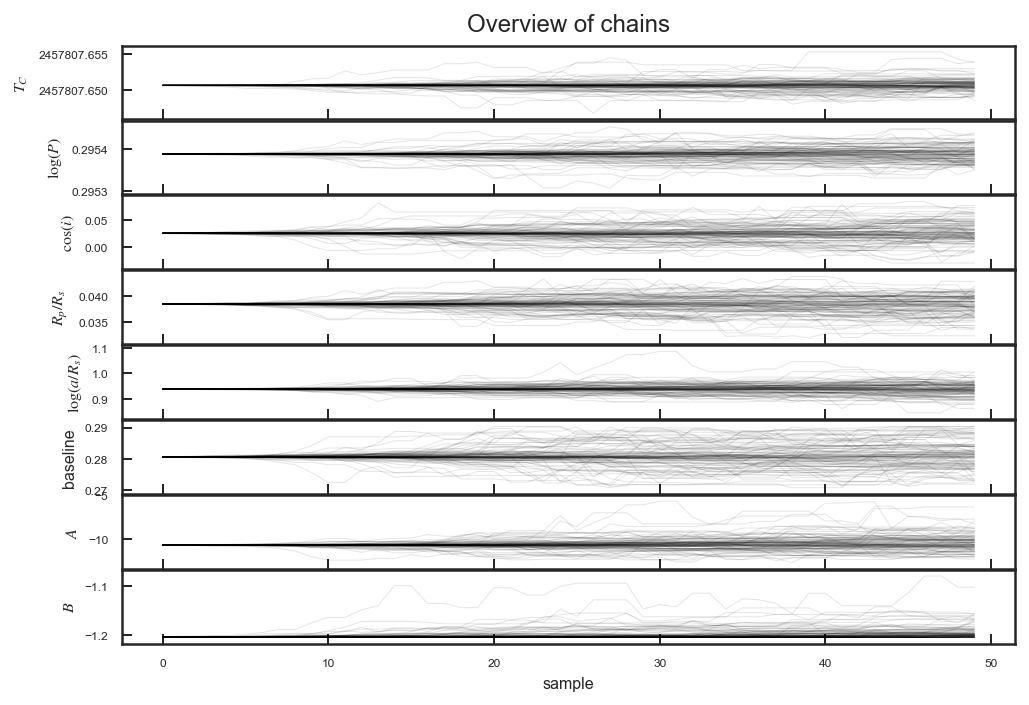

In [14]:
GG.plot_chains()

Plotting cornerplot


IOError: [Errno 2] No such file or directory: '/Users/Sophie/Desktop/test.pdf'

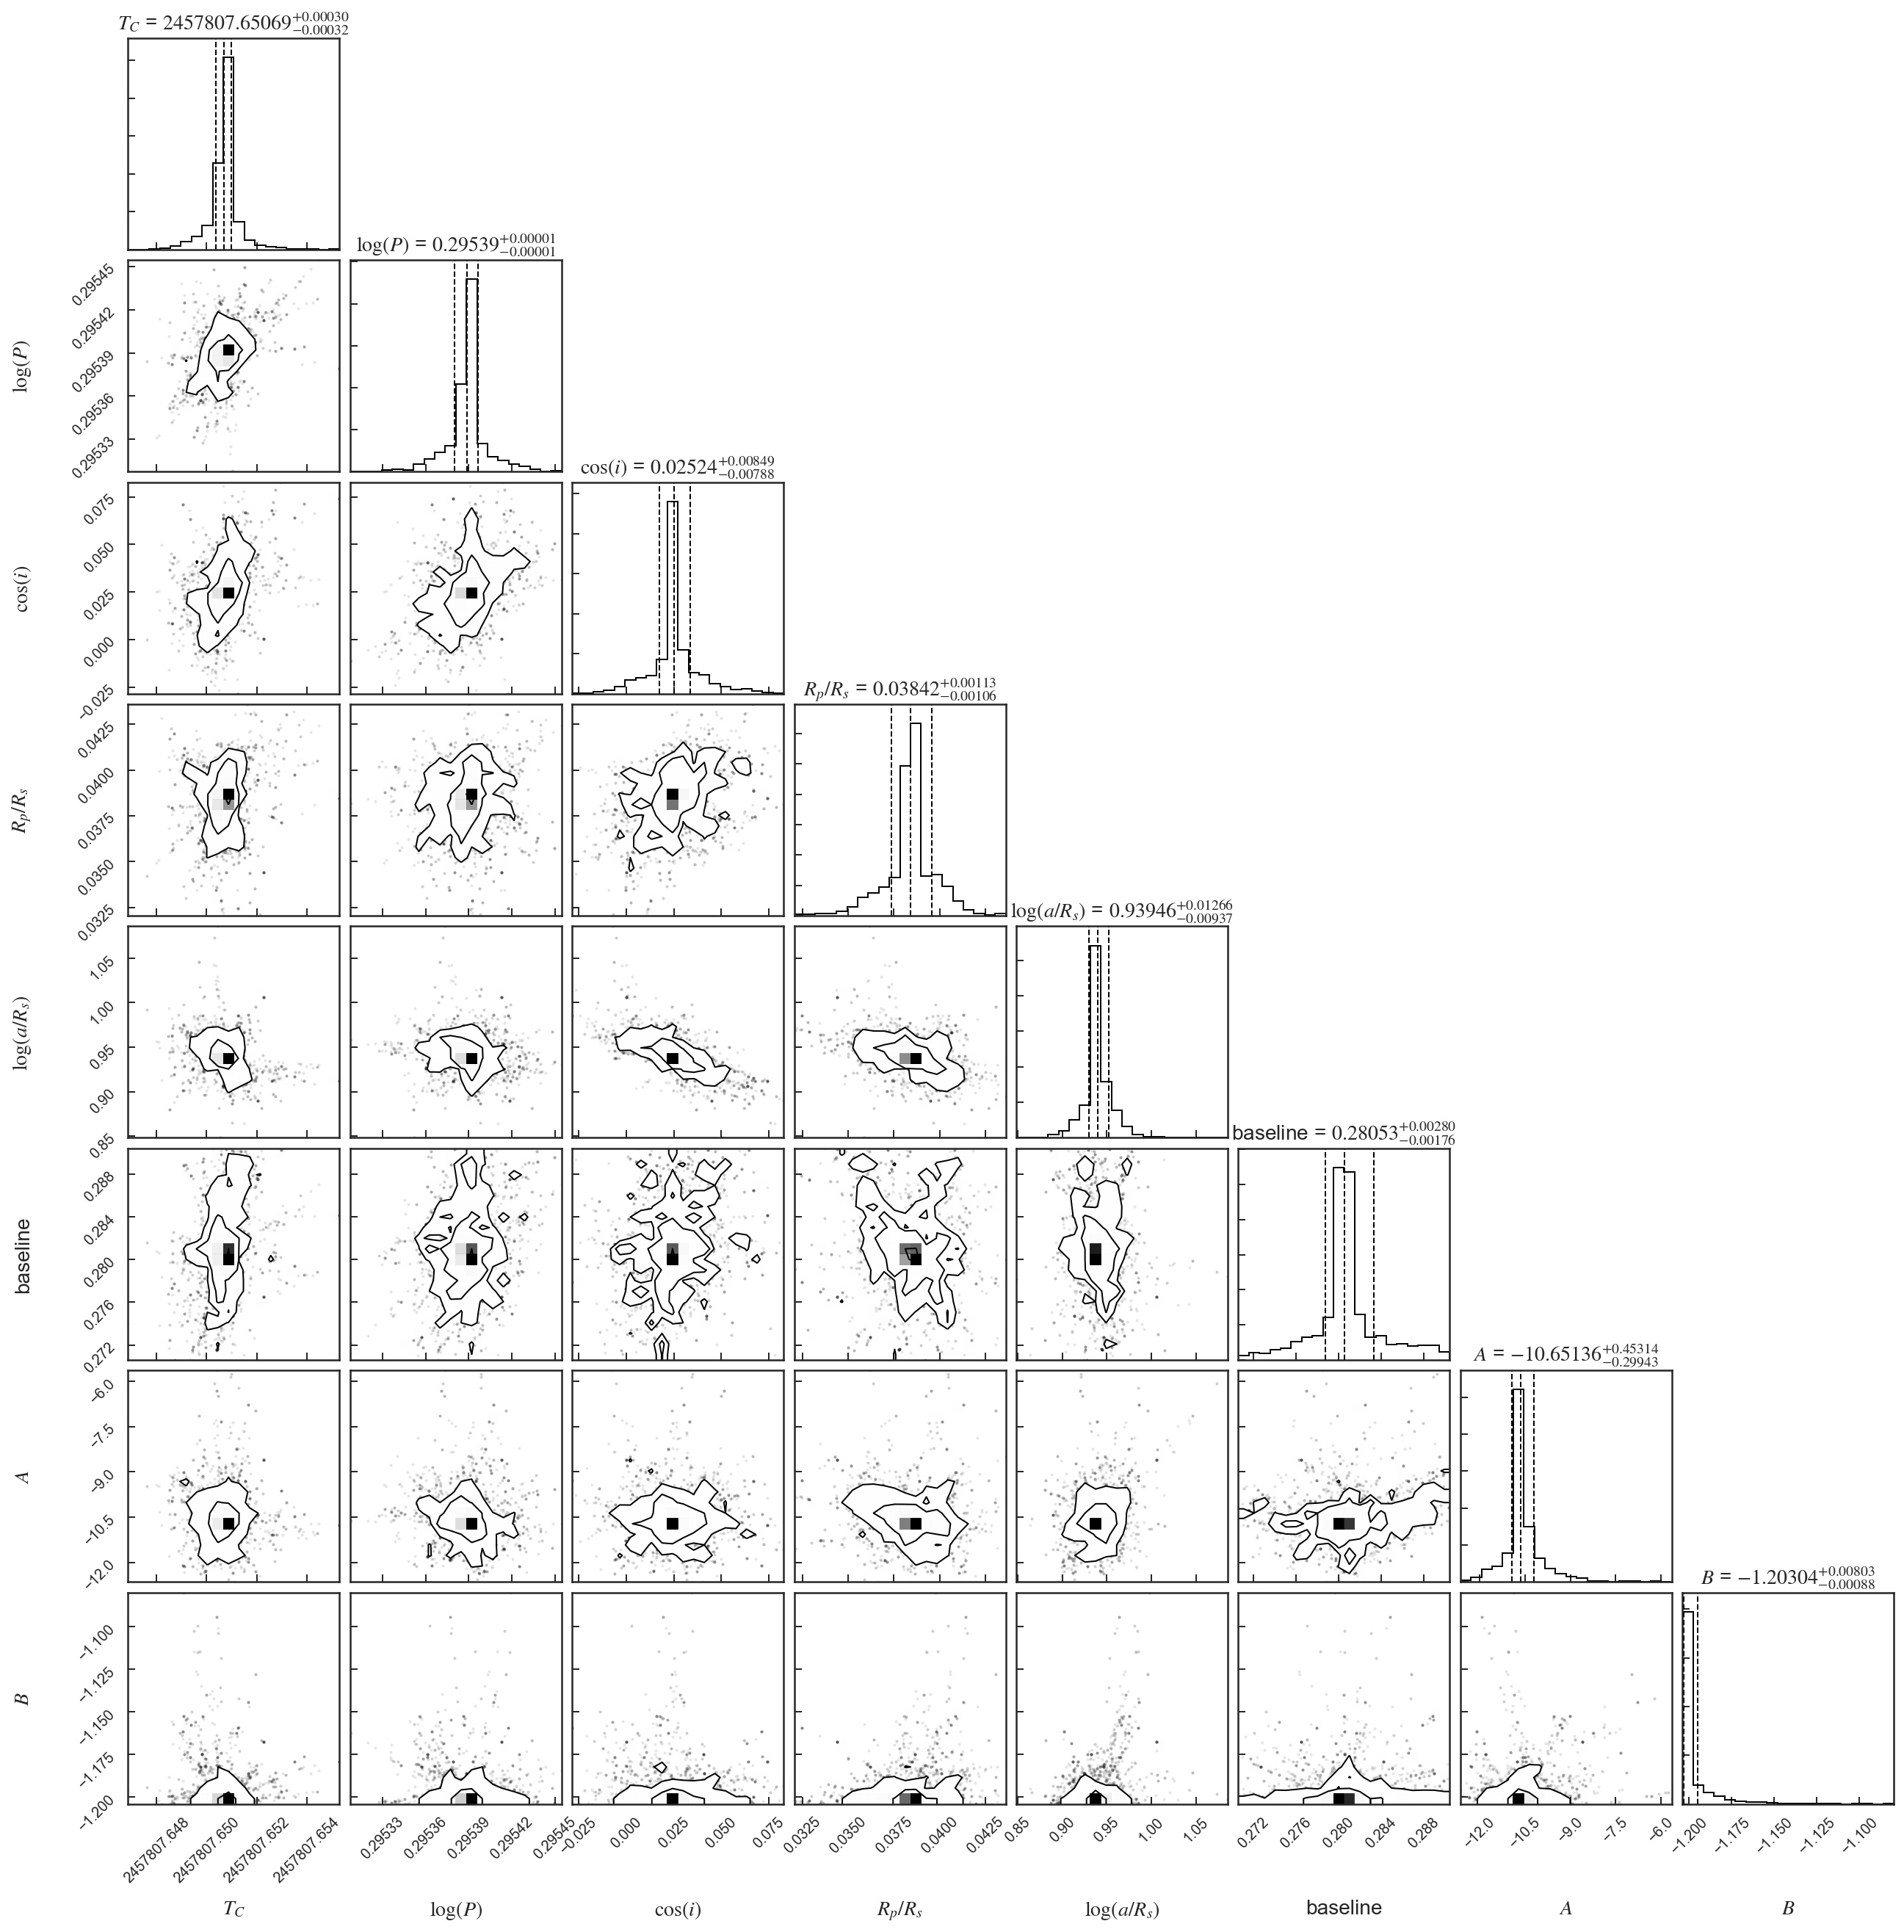

In [15]:
GG.plot_corner(burn=0,show_titles=True)

#### Only interesting parameters corner plot

Plotting cornerplot


IOError: [Errno 2] No such file or directory: '/Users/Sophie/Desktop/test.pdf'

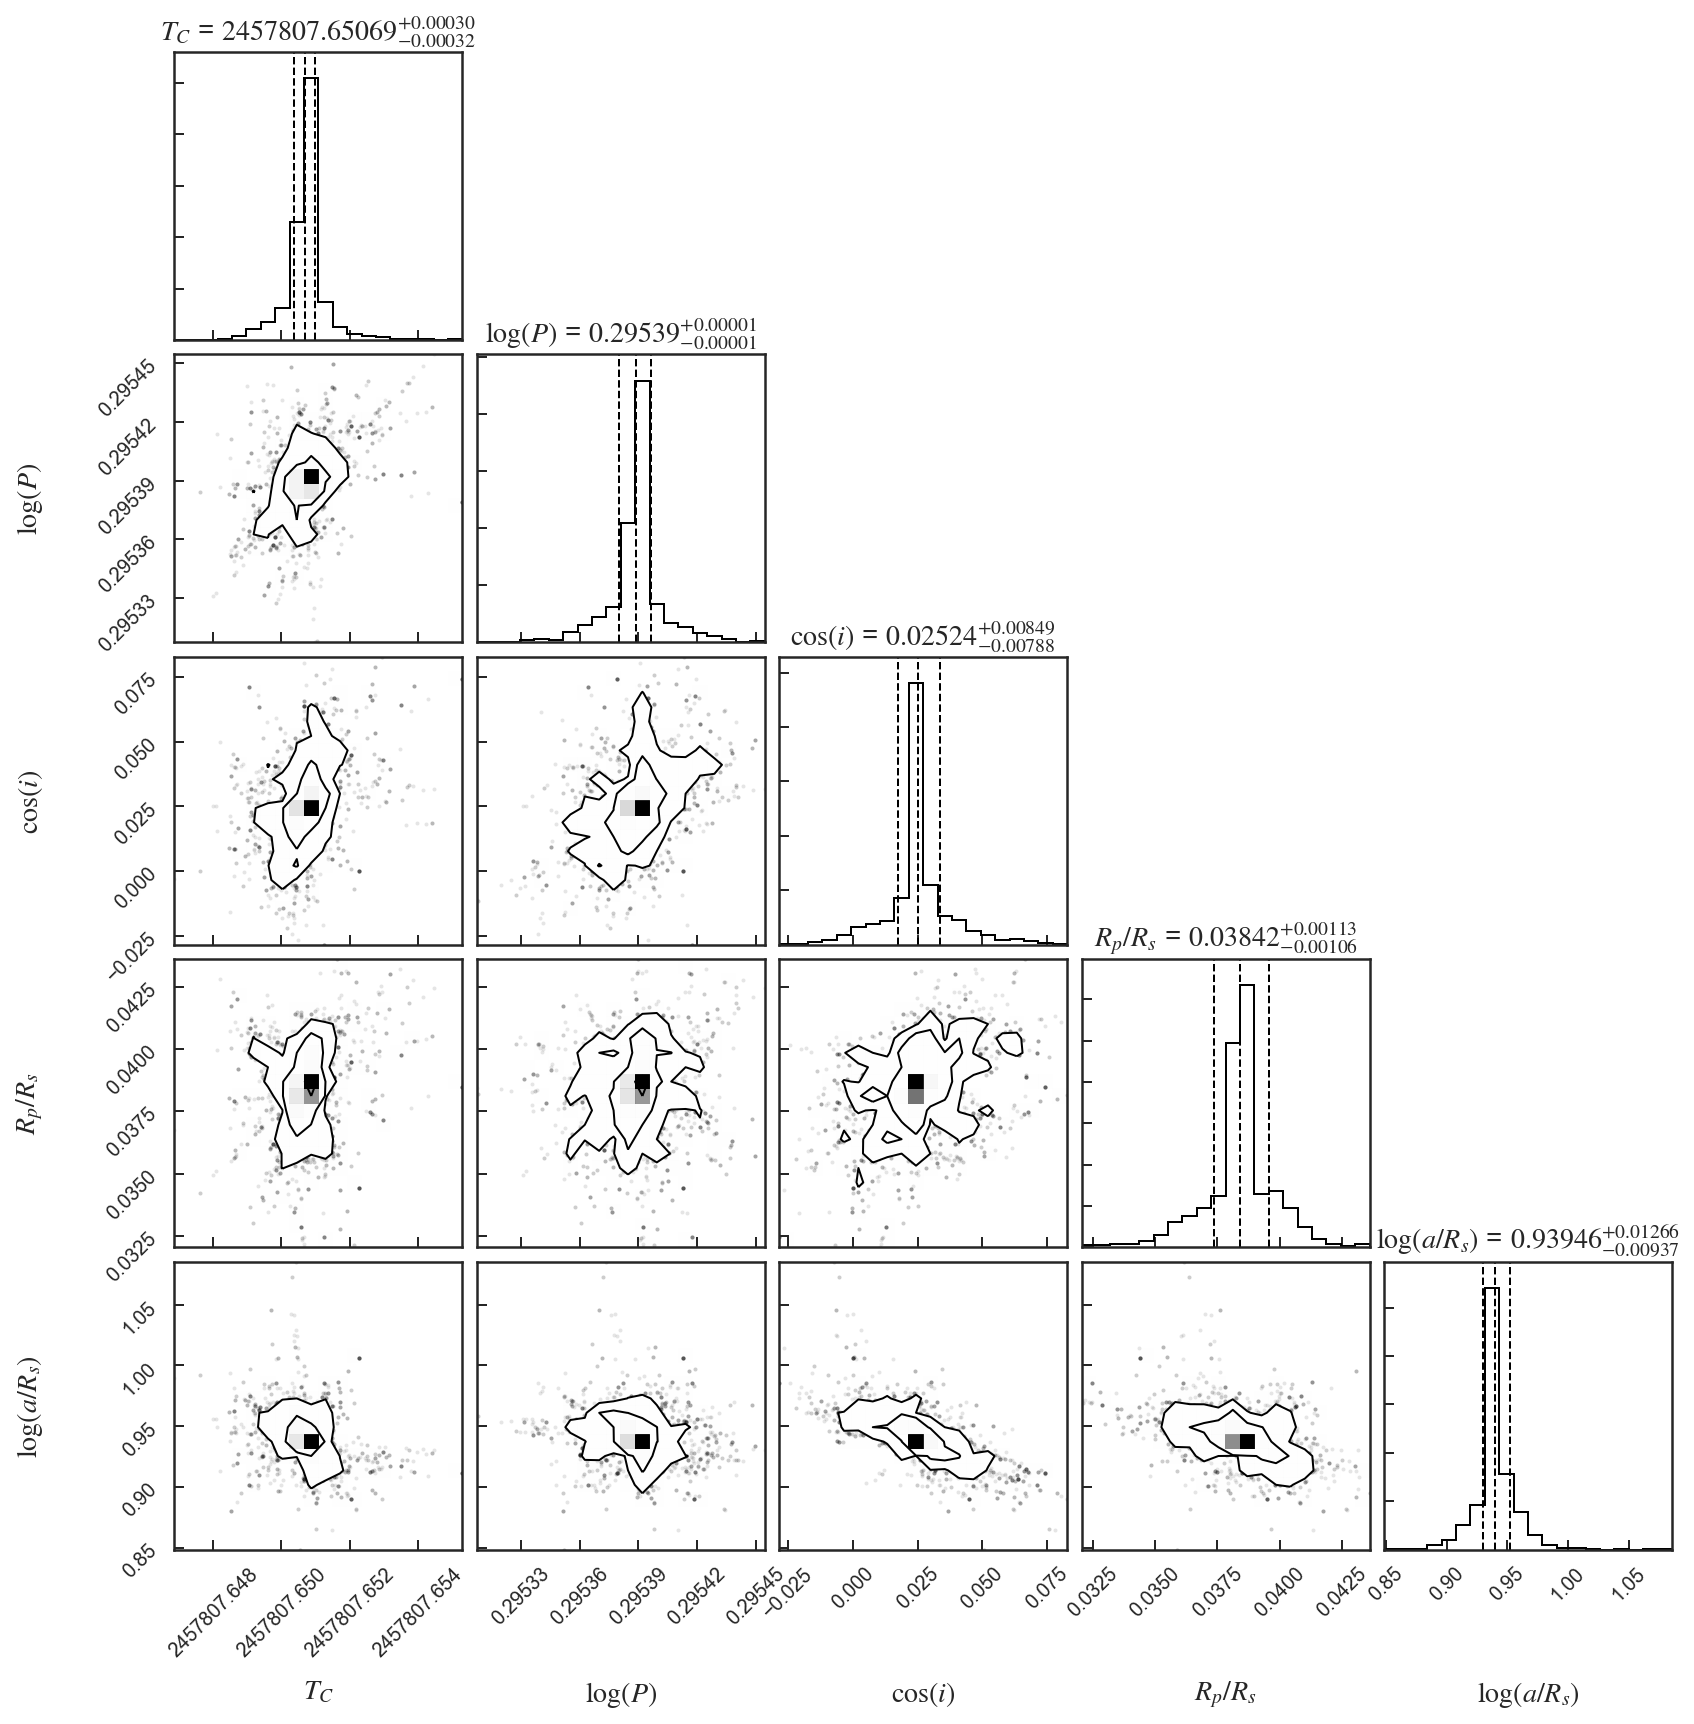

In [16]:
mcFunc.plot_corner(GG.sampler.chain[:,:,:5],labels=GG.lpf.ps.descriptions[:5],burn=0,title_fmt='.5f',show_titles=True)

#### Get transit parameters

In [17]:
df = GG.get_transit_parameters(st_rad=0.29,st_raderr1=0.03,st_teff=3214.,st_teff_err1=60.,burn=0)
df

Assuming
('R_s:', 0.29, '+-', 0.03)
('Teff:', 3214.0, '+-', 60.0)
16


,medvals,minus,plus,values,Labels,Description
0,2.457808e+06,0.000321,0.000296,$2457807.65069_{-0.00032}^{+0.00030}$,$T_{0}$ $(\mathrm{BJD_{TDB}})$,Transit Midpoint
1,1.974190e+00,0.000041,0.000033,$1.97419_{-0.00004}^{+0.00003}$,$P$ (days),Orbital period
2,3.841509e-02,0.001063,0.001134,$0.0384_{-0.0011}^{+0.0011}$,$R_p/R_*$,Radius ratio
3,1.212934e+00,0.134738,0.132052,$1.21_{-0.13}^{+0.13}$,$R_p (R_\oplus)$,Planet radius
4,1.082115e-01,0.012021,0.011781,$0.108_{-0.012}^{+0.012}$,$R_p (R_J)$,Planet radius
5,1.475719e-03,0.000081,0.000088,$0.001476_{-0.00008}^{+0.00009}$,$\delta$,Transit depth
6,8.698887e+00,0.185731,0.257285,$8.7_{-0.19}^{+0.26}$,$a/R_*$,Normalized orbital radius
7,1.175315e-02,0.001283,0.001273,$0.0118_{-0.0013}^{+0.0013}$,$a$ (AU),Semi-major axis
8,8.855382e+01,0.486916,0.451864,$88.55_{-0.49}^{+0.45}$,$i$ $(^{\circ})$,Transit inclination
9,2.193075e-01,0.064751,0.070389,$0.219_{-0.065}^{+0.070}$,$b$,Impact parameter


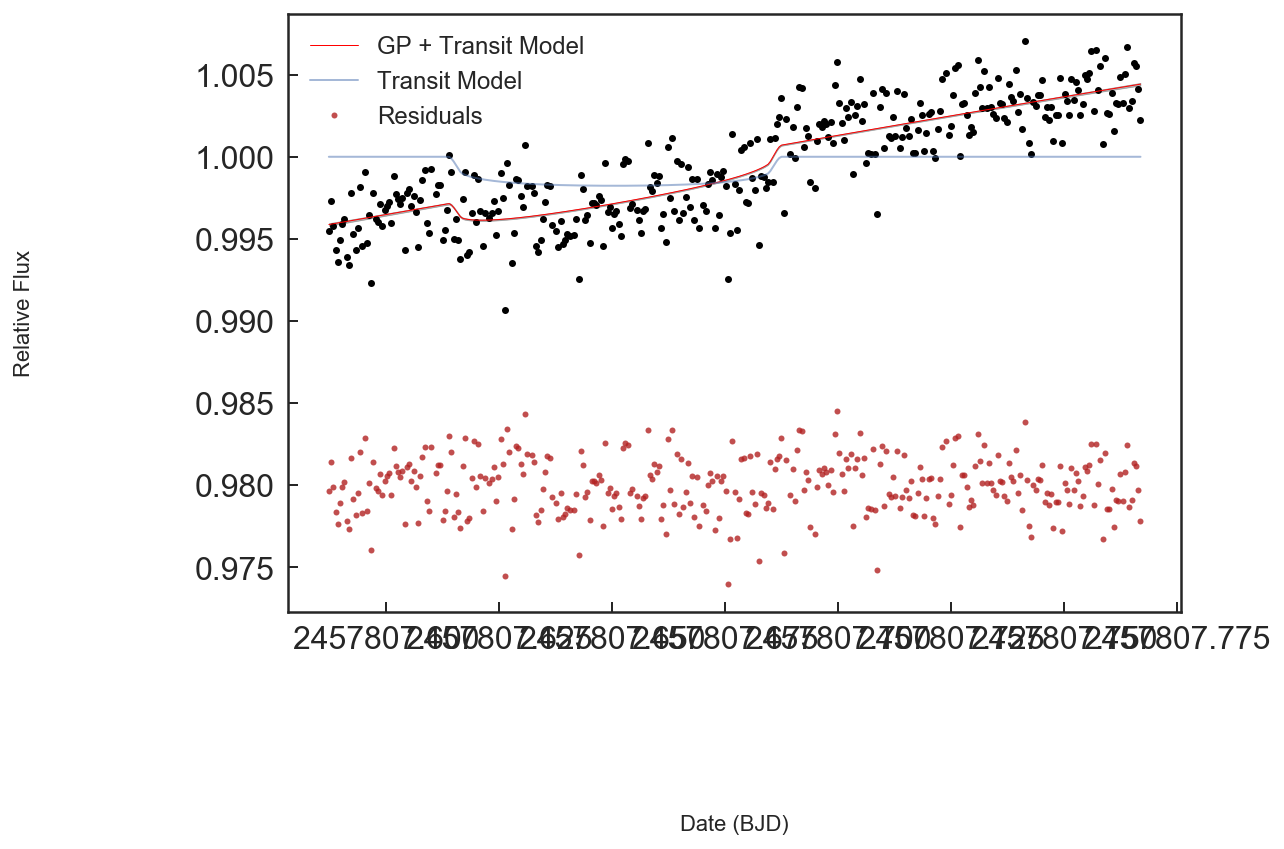

In [18]:
GG.plot_lc(draw_posteriors=False)